<a href="https://colab.research.google.com/github/TristanG0/EMEA-Healthcare-Sales-Commercial-Analytics-Platform/blob/main/EMEA_Healthcare_Sales_%26_Commercial_Analytics_Platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')


In [2]:
np.random.seed(42)

data = {
    "Order_Date": pd.date_range(start="2022-01-01", periods=800, freq="D"),
    "Region": ["EMEA"] * 800,
    "Country": np.random.choice(
        ["Germany", "France", "UK", "Italy", "Spain", "Netherlands", "South Africa"],
        size=800
    ),
    "Product_Category": np.random.choice(
        ["Orthopaedics", "MedSurg", "Neurotechnology"],
        size=800
    ),
    "Units_Sold": np.random.randint(1, 120, size=800),
    "Unit_Price_EUR": np.random.randint(300, 5000, size=800)
}

df = pd.DataFrame(data)

df["Revenue_EUR"] = df["Units_Sold"] * df["Unit_Price_EUR"]

df.head()


,Order_Date,Region,Country,Product_Category,Units_Sold,Unit_Price_EUR,Revenue_EUR
0,2022-01-01,EMEA,South Africa,Neurotechnology,116,3034,351944
1,2022-01-02,EMEA,Italy,Orthopaedics,107,2512,268784
2,2022-01-03,EMEA,Spain,Neurotechnology,81,2652,214812
3,2022-01-04,EMEA,South Africa,Orthopaedics,62,3868,239816
4,2022-01-05,EMEA,UK,MedSurg,109,1955,213095


## Data Governance & Definitions

| Column Name | Definition | Source | Calculation |
|-----------|-----------|--------|-------------|
| Order_Date | Date of transaction | Simulated sales data | N/A |
| Region | Sales region | Commercial structure | Fixed value (EMEA) |
| Country | Country of sale | Sales record | N/A |
| Product_Category | Product division | Product hierarchy | N/A |
| Units_Sold | Number of units sold | Transaction data | N/A |
| Unit_Price_EUR | Price per unit | Pricing data | N/A |
| Revenue_EUR | Total sales revenue | Derived | Units_Sold × Unit_Price_EUR |

### Assumptions
- All prices are standardized in EUR
- Data reflects commercial sales transactions
- Dataset represents aggregated transactional sales


In [3]:
df.isna().sum()


,0
Order_Date,0
Region,0
Country,0
Product_Category,0
Units_Sold,0
Unit_Price_EUR,0
Revenue_EUR,0


In [4]:
df["Order_Date"] = pd.to_datetime(df["Order_Date"])
df["Country"] = df["Country"].str.strip()

df.describe()


,Order_Date,Units_Sold,Unit_Price_EUR,Revenue_EUR
count,800,800.000000,800.000000,800.000000
mean,2023-02-04 12:00:00,59.500000,2625.633750,156555.925000
min,2022-01-01 00:00:00,1.000000,307.000000,1512.000000
25%,2022-07-19 18:00:00,29.000000,1432.750000,50167.500000
50%,2023-02-04 12:00:00,60.000000,2653.500000,119496.000000
75%,2023-08-23 06:00:00,90.000000,3826.250000,230505.000000
max,2024-03-10 00:00:00,119.000000,4997.000000,592144.000000
std,NaN,34.570419,1343.241872,131985.364753


In [5]:
conn = sqlite3.connect(":memory:")

df.to_sql("sales_data", conn, index=False, if_exists="replace")

pd.read_sql("SELECT * FROM sales_data LIMIT 5", conn)


,Order_Date,Region,Country,Product_Category,Units_Sold,Unit_Price_EUR,Revenue_EUR
0,2022-01-01 00:00:00,EMEA,South Africa,Neurotechnology,116,3034,351944
1,2022-01-02 00:00:00,EMEA,Italy,Orthopaedics,107,2512,268784
2,2022-01-03 00:00:00,EMEA,Spain,Neurotechnology,81,2652,214812
3,2022-01-04 00:00:00,EMEA,South Africa,Orthopaedics,62,3868,239816
4,2022-01-05 00:00:00,EMEA,UK,MedSurg,109,1955,213095


In [6]:
query = """
SELECT
    Product_Category,
    ROUND(SUM(Revenue_EUR), 2) AS Total_Revenue_EUR
FROM sales_data
GROUP BY Product_Category
ORDER BY Total_Revenue_EUR DESC
"""

pd.read_sql(query, conn)


,Product_Category,Total_Revenue_EUR
0,Orthopaedics,43327276.0
1,MedSurg,42164540.0
2,Neurotechnology,39752924.0


### Insight
Orthopaedics and MedSurg are the top revenue-generating product categories, indicating
where commercial focus and investment currently yield the highest returns.


In [7]:
query = """
SELECT
    Country,
    ROUND(SUM(Revenue_EUR), 2) AS Total_Revenue_EUR
FROM sales_data
GROUP BY Country
ORDER BY Total_Revenue_EUR DESC
"""

pd.read_sql(query, conn)


,Country,Total_Revenue_EUR
0,South Africa,20488860.0
1,Italy,18772763.0
2,France,17811056.0
3,Germany,17654923.0
4,Spain,17321084.0
5,Netherlands,17250606.0
6,UK,15945448.0


### Insight
Revenue concentration varies significantly across EMEA countries, suggesting
opportunities for targeted commercial strategies in underperforming markets.


In [8]:
query = """
SELECT
    strftime('%Y-%m', Order_Date) AS Month,
    ROUND(SUM(Revenue_EUR), 2) AS Monthly_Revenue_EUR
FROM sales_data
GROUP BY Month
ORDER BY Month
"""

monthly_sales = pd.read_sql(query, conn)
monthly_sales.head()


,Month,Monthly_Revenue_EUR
0,2022-01,4300741.0
1,2022-02,4887817.0
2,2022-03,4270215.0
3,2022-04,5525844.0
4,2022-05,4316892.0


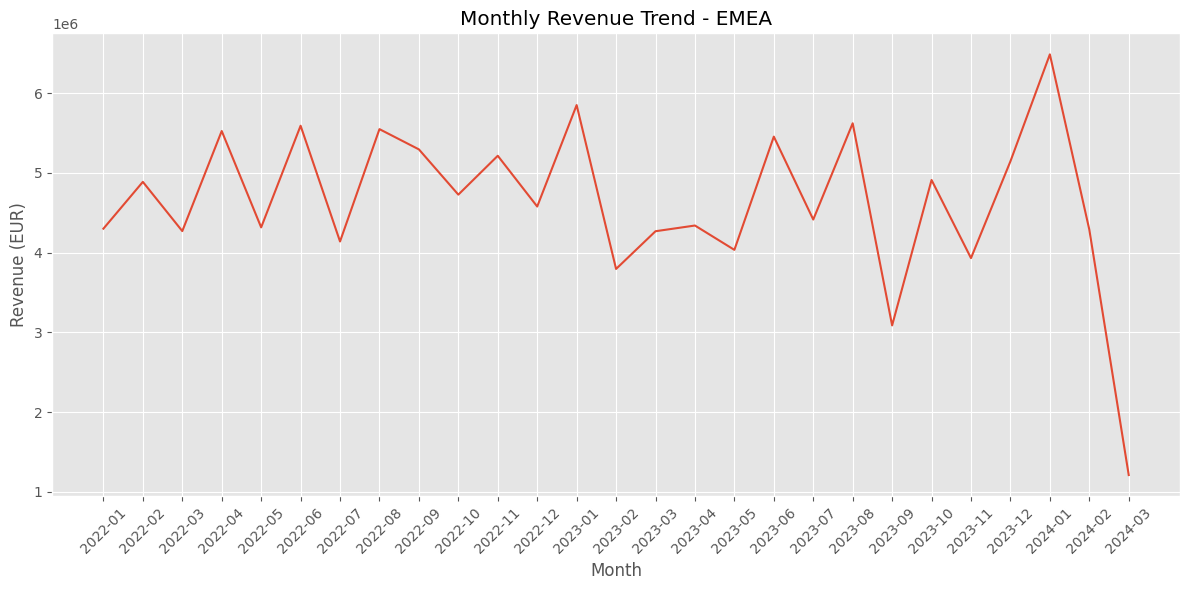

In [9]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales["Month"], monthly_sales["Monthly_Revenue_EUR"])
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend - EMEA")
plt.xlabel("Month")
plt.ylabel("Revenue (EUR)")
plt.tight_layout()
plt.show()


### Insight
The revenue trend shows fluctuations across months, highlighting seasonal patterns
that should be considered for sales planning and inventory management.


In [10]:
total_revenue = df["Revenue_EUR"].sum()
avg_order_value = df["Revenue_EUR"].mean()
total_units = df["Units_Sold"].sum()

pd.DataFrame({
    "KPI": ["Total Revenue (EUR)", "Average Order Value (EUR)", "Total Units Sold"],
    "Value": [round(total_revenue,2), round(avg_order_value,2), total_units]
})


,KPI,Value
0,Total Revenue (EUR),1.252447e+08
1,Average Order Value (EUR),1.565559e+05
2,Total Units Sold,4.760000e+04


### KPI Interpretation
These KPIs form the foundation for executive dashboards in Power BI, enabling
leadership to track overall performance, order value trends, and commercial scale.


/tmp/ipython-input-3570526031.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(key="Order_Date", freq="M"), "Product_Category"]


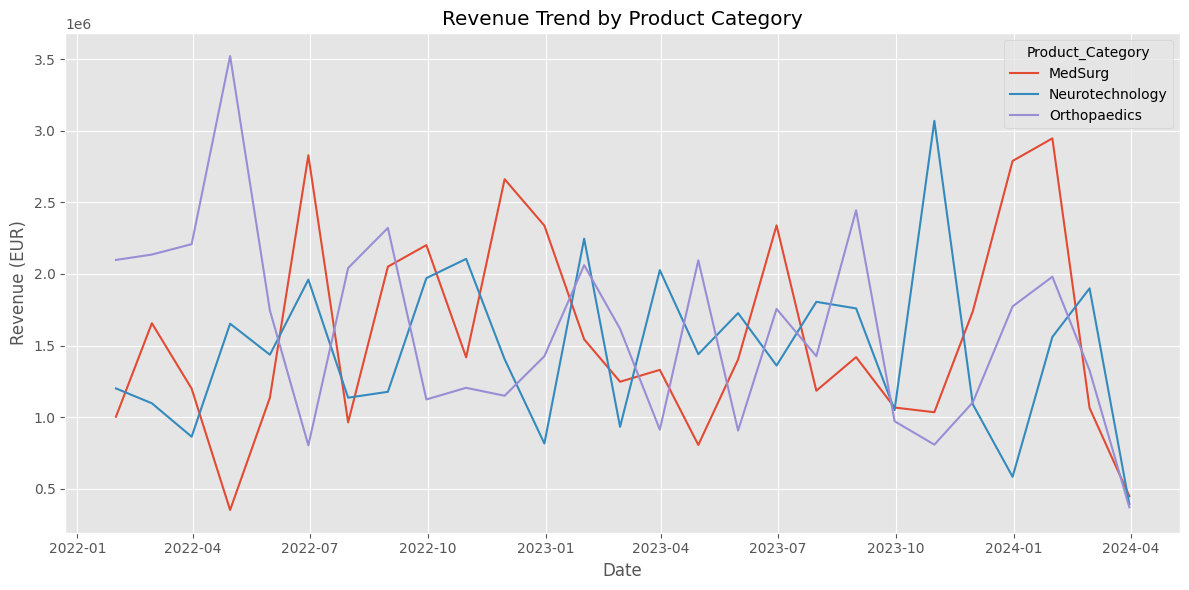

In [11]:
category_trend = df.groupby(
    [pd.Grouper(key="Order_Date", freq="M"), "Product_Category"]
)["Revenue_EUR"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(
    data=category_trend,
    x="Order_Date",
    y="Revenue_EUR",
    hue="Product_Category"
)
plt.title("Revenue Trend by Product Category")
plt.xlabel("Date")
plt.ylabel("Revenue (EUR)")
plt.tight_layout()
plt.show()


### Insight
Different product categories exhibit distinct growth patterns, suggesting
category-specific commercial strategies rather than a one-size-fits-all approach.


## Executive Summary & Recommendations

### Key Findings
- Orthopaedics and MedSurg are the primary revenue drivers in EMEA
- Revenue performance varies significantly across countries
- Seasonal trends impact monthly sales performance
- Product categories show distinct growth trajectories

### Recommendations
- Focus commercial efforts on high-performing product categories while
  investigating underperforming markets
- Align sales planning and inventory management with observed seasonal trends
- Implement automated SQL-driven dashboards to reduce manual reporting
- Expand analytics capabilities to include forecasting and external market data

### Business Impact
This analytics solution demonstrates how scalable data capabilities can shift
commercial teams from manual reporting to insight-driven decision-making.
